Indexing is already done for the corpus. I take here the index path and trec6 topic file (50 queries). Then perform LMJM for lambda = 0.1 - 0.9 (with step_size = 0.1). Plot the lambda vs MAP. Choose lambda correspodning to the highest MAP value. Use this optimal trained lambda paramter of LMJM for baseline model.

In [1]:
topicFilePath = './trec6.xml'  # 50 queries

import xml.etree.ElementTree as ET

tree = ET.parse(topicFilePath)
topics = tree.getroot()

In [2]:
import lucene
from org.apache.lucene.search import IndexSearcher
from org.apache.lucene.index import DirectoryReader
from org.apache.lucene.store import FSDirectory
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.search.similarities import BM25Similarity
from org.apache.lucene.search.similarities import LMJelinekMercerSimilarity
from org.apache.lucene.search.similarities import LMDirichletSimilarity
from org.apache.lucene.analysis.en import EnglishAnalyzer
from java.io import File

In [3]:
lucene.initVM()

In [4]:
indexPath = File("index/").toPath()
directory = FSDirectory.open(indexPath)
indexReader = DirectoryReader.open(directory)

### LMJM Retrieval

In [5]:
def lmjm(LAMBDA):
    model = 'lmjm'
    similarityModel = LMJelinekMercerSimilarity(LAMBDA)

    # change result file path below
    outputPath = f'./Baseline LMJM//LMJM_{LAMBDA}.res'
    f = open(outputPath, 'w')

    # setting up the searcher
    analyzer = EnglishAnalyzer()    # used same analyzer as indexer
    index_path = './index/'
    directory = FSDirectory.open(File(index_path).toPath())
    searcher = IndexSearcher(DirectoryReader.open(directory))

    print('\nRetrieving ...')

    # search on 50 queries from the topic file 'trec6.xml'
    for topic in topics:
        qidField = 'num'
        queryKeywordsField = 'title'     # other fields are 'desc'and 'narr'

        qid = topic.find(qidField).text.strip()
        q = topic.find(queryKeywordsField).text.strip()

        # setting the similarity model
        searcher.setSimilarity(similarityModel)

        escaped_q = QueryParser('CONTENT', analyzer).escape(q)      # a few titles had '/' in them which 
                                                                    # EnglishAnalyzer was not able to parse
                                                                    # without escaping those special characters
        query = QueryParser('CONTENT', analyzer).parse(escaped_q)

        print(f'LMJM, lambda = {LAMBDA}; qid = {qid}, retrieving & writing ...', end=' ')

        # getting the top k search results using the searcher
        k = 1000
        scoreDocs = searcher.search(query, k).scoreDocs

        # writing all k doc results in a .res file in trec format
        rank = 0
        for scoreDoc in scoreDocs:
            rank += 1
            doc = searcher.doc(scoreDoc.doc)
            # print(qid,'Q0', doc.get('DOCID'), rank, scoreDoc.score, f'aman_{method}_{LAMBDA}')
            f.write(f"{qid}\tQ0\t{doc.get('DOCID')}\t{rank}\t{scoreDoc.score}\taman_{model}_{LAMBDA}\n")

        print('complete!')

    f.close()
    print('Search completed! Search results exported to a .res file in the current directory.\n')

In [6]:
lambda_range = [i/10 for i in range(1,10)]      # lambda = 0.1, 0.2,..., 0.9
for LAMBDA in lambda_range:
    lmjm(LAMBDA)


Retrieving ...
LMJM, lambda = 0.1; qid = 301, retrieving & writing ... complete!
LMJM, lambda = 0.1; qid = 302, retrieving & writing ... complete!
LMJM, lambda = 0.1; qid = 303, retrieving & writing ... complete!
LMJM, lambda = 0.1; qid = 304, retrieving & writing ... complete!
LMJM, lambda = 0.1; qid = 305, retrieving & writing ... complete!
LMJM, lambda = 0.1; qid = 306, retrieving & writing ... complete!
LMJM, lambda = 0.1; qid = 307, retrieving & writing ... complete!
LMJM, lambda = 0.1; qid = 308, retrieving & writing ... complete!
LMJM, lambda = 0.1; qid = 309, retrieving & writing ... complete!
LMJM, lambda = 0.1; qid = 310, retrieving & writing ... complete!
LMJM, lambda = 0.1; qid = 311, retrieving & writing ... complete!
LMJM, lambda = 0.1; qid = 312, retrieving & writing ... complete!
LMJM, lambda = 0.1; qid = 313, retrieving & writing ... complete!
LMJM, lambda = 0.1; qid = 314, retrieving & writing ... complete!
LMJM, lambda = 0.1; qid = 315, retrieving & writing ... comp

### Plot of lambda vs MAP for LMJM

In [5]:
import subprocess

In [7]:
lambda_range = [i/10 for i in range(1,10)]      # lambda = 0.1, 0.2,..., 0.9

In [8]:
X = []  # LAMBDAs
Y = []  # MAPs

for LAMBDA in lambda_range:
    result = subprocess.run(['trec_eval', 'trec678_robust.qrel', f'LMJM_{LAMBDA}.res'], stdout=subprocess.PIPE)
    shell_output_string = result.stdout.decode('utf-8')
    if shell_output_string.split()[15] == 'map':
        map_value = float(shell_output_string.split()[17])
        X.append(LAMBDA)
        Y.append(map_value)
    else:
        raise Exception('map_value index misalignment')

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
%matplotlib inline

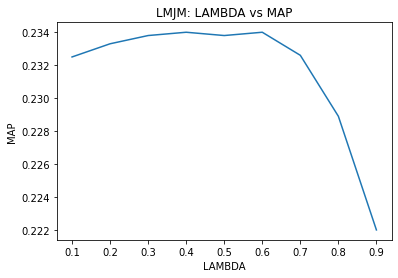

In [28]:
plt.plot(X,Y)
plt.title('LMJM: LAMBDA vs MAP')
plt.xlabel('LAMBDA')
plt.ylabel('MAP')
plt.savefig('./Baseline LMJM/LMJM LAMBDA vs MAP plot.png', facecolor='white', transparent=False, dpi=300)
plt.show()

In [21]:
# writing LMJM LAMBDAs and MAPs to a tsv file for future reference

import csv

with open('./Baseline LMJM//LMJM_lambda_vs_MAP.tsv', 'wt') as f:
    tsv_writer = csv.writer(f, delimiter='\t')
    tsv_writer.writerow(['method','LAMBDA','MAP'])
    for i in range(len(X)):
        tsv_writer.writerow(['lmjm',X[i],Y[i]])

In [24]:
# LAMBDA corresponding to highest MAP
index_max = max(range(len(Y)), key=Y.__getitem__)
print(f'Max MAP = {Y[index_max]} for LAMBDA = {X[index_max]}')

Max MAP = 0.234 for LAMBDA = 0.4
